In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import optuna
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb


pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)
path = "/kaggle/working/"
df = pd.read_csv(r"/kaggle/input/restaurant-revenue-prediction/train.csv.zip")
test = pd.read_csv(r"/kaggle/input/restaurant-revenue-prediction/test.csv.zip")
sub = pd.read_csv(r"/kaggle/input/restaurant-revenue-prediction/sampleSubmission.csv")


In [2]:
df.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.000,4.000,4.000,2,2,5,4,5,5,3,5,5.000,1,2,2,2,4,5,4,1,3,3,1,1,1.000,4.000,2.000,3.000,5,3,4,5,5,4,3,4,5653753.000
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.000,4.000,4.000,1,2,5,5,5,5,1,5,5.000,0,0,0,0,0,3,2,1,3,2,0,0,0.000,0.000,3.000,3.000,0,0,0,0,0,0,0,0,6923131.000
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.000,2.000,5.000,2,3,5,5,5,5,2,5,5.000,0,0,0,0,0,1,1,1,1,1,0,0,0.000,0.000,1.000,3.000,0,0,0,0,0,0,0,0,2055379.000
3,3,02/02/2012,Tokat,Other,IL,6,4.500,6.000,6.000,4,4,10,8,10,10,8,10,7.500,6,4,9,3,12,20,12,6,1,10,2,2,2.500,2.500,2.500,7.500,25,12,10,6,18,12,12,6,2675511.000
4,4,05/09/2009,Gaziantep,Other,IL,3,4.000,3.000,4.000,2,2,5,5,5,5,2,5,5.000,2,1,2,1,4,2,2,1,2,1,2,3,3.000,5.000,1.000,3.000,5,1,3,2,3,4,3,3,4316715.000


In [3]:
df.drop(columns=['Id','Open Date', 'City', 'City Group', 'Type'], inplace=True)

In [4]:
df['revenue'].describe()

count        137.000
mean     4453532.613
std      2576071.596
min      1149870.000
25%      2999068.000
50%      3939804.000
75%      5166635.000
max     19696939.000
Name: revenue, dtype: float64

In [5]:
y = df['revenue']
X = df.drop(columns='revenue')


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  train_size=0.75,
                                                  random_state=42)

print(f'Train: {X_train.shape[0]} samples \t {round(X_train.shape[0] / X.shape[0] * 100)}%')
print(f'Test:  {X_test.shape[0]} samples \t {round(X_test.shape[0] / X.shape[0] * 100)}%')
print(f'Val:   {X_val.shape[0]} samples \t {round(X_val.shape[0] / X.shape[0] * 100)}%')

Train: 81 samples 	 59%
Test:  28 samples 	 20%
Val:   28 samples 	 20%


In [7]:
num_columns = X.select_dtypes(include="number").columns
cat_columns = X.select_dtypes(include="object").columns

num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
    )

cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", OneHotEncoder(sparse_output=False))])


preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_columns),
        ("cat", cat_transformer, cat_columns),
    ]
)

preprocessor.set_output(transform='pandas')
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 Index([], dtype='object'))])

In [8]:
X_train = preprocessor.fit_transform(X_train)

X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [9]:
from sklearn import metrics


def objective(trial):

  params = {
        "objective": "mse",
        "verbosity": -1,
        "n_estimators": 30,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
  }

  model = lgb.LGBMRegressor(**params)

  model.fit(X_train, y_train)


  y_pred = model.predict(X_val)
  r2 = metrics.r2_score(y_val, y_pred)

  return r2


In [10]:
optuna.logging.set_verbosity(optuna.logging.WARNING) 

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[LightGBM] [Warning] bagging_fraction is set=0.4139868226682653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4139868226682653
[LightGBM] [Warning] lambda_l2 is set=5.074743669481172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.074743669481172
[LightGBM] [Warning] lambda_l1 is set=0.0005872949081109764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005872949081109764
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8214875417377179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8214875417377179
[LightGBM] [Warning] bagging_fraction is set=0.916577683456022, subsample=1.0 will be ignored. Current value: bagging_fraction=0.916577683456022
[LightGBM] [Warning] lambda_l2 is set=2.4530017807806427e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4530017807806427e-07
[LightGBM] [Warning] lambda_l1 is

In [11]:
print(f"найкраща метрика: {study.best_value}")

найкраща метрика: 0.23170622102348692


In [12]:
  model = lgb.LGBMRegressor(**study.best_params)

model.fit(X_train, y_train,           
          eval_set=[(X_test, y_test), (X_train, y_train)],           
          eval_names = [
'test'
,
'train'
],           eval_metric=
'mae'
)

[LightGBM] [Warning] lambda_l1 is set=6.072106186738798e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.072106186738798e-08
[LightGBM] [Warning] feature_fraction is set=0.4468570840467368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4468570840467368
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0003806753771214983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003806753771214983
[LightGBM] [Warning] bagging_fraction is set=0.45479204940648704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45479204940648704
[1]	train's l1: 1.27097e+06	train's l2: 2.76308e+12	test's l1: 2.02784e+06	test's l2: 1.27515e+13
[2]	train's l1: 1.25625e+06	train's l2: 2.64797e+12	test's l1: 2.07871e+06	test's l2: 1.27669e+13
[3]	train's l1: 1.30305e+06	train's l2: 2.76823e+12	test's l1: 2.05575e+06	test's l2: 1.22765e+13
[4]	train's l1: 

LGBMRegressor(bagging_fraction=0.45479204940648704, bagging_freq=6,
              feature_fraction=0.4468570840467368,
              lambda_l1=6.072106186738798e-08, lambda_l2=0.0003806753771214983,
              learning_rate=0.8584188406240723, min_child_samples=12,
              num_leaves=175)

In [13]:
def get_metrics(y_true, y_pred, name="model"):
  df = pd.DataFrame()

  df.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
  df.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  df.loc["R2", name] = metrics.r2_score(y_true, y_pred)

  return df.round(2)

In [14]:
all_metrics = pd.DataFrame()

all_metrics["train"] = get_metrics(y_train, model.predict(X_train))
all_metrics["test"] = get_metrics(y_test, model.predict(X_test))

all_metrics

,train,test
MAE,1082921.580,2374060.800
RMSE,1462438.900,3968238.500
R2,0.270,-0.290


In [15]:
optuna.visualization.plot_param_importances(study)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

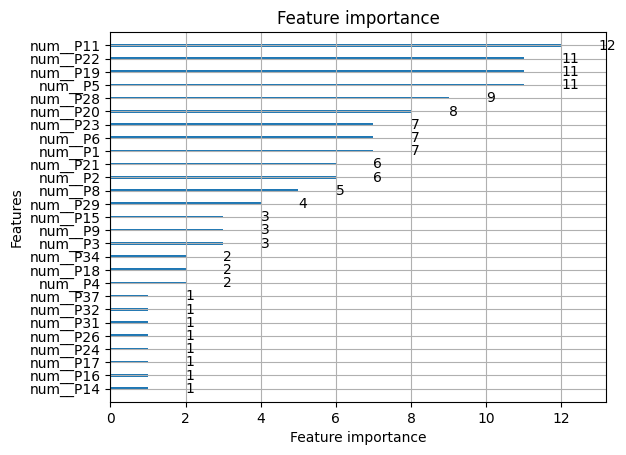

In [16]:
lgb.plot_importance(model)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

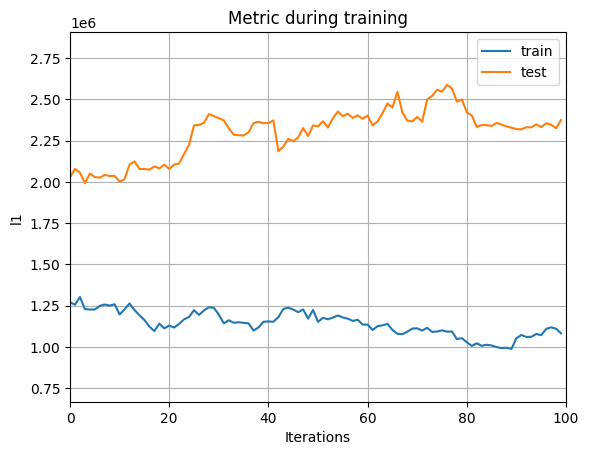

In [17]:
import lightgbm as lgb
lgb.plot_metric(model,
                metric='l1')